In [34]:
from qiskit import BasicAer, Aer, IBMQ
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.aqua.algorithms import VQE, NumPyEigensolver
from qiskit.aqua.components.initial_states import Zero
from qiskit.aqua.components.optimizers import COBYLA, L_BFGS_B, SLSQP, SPSA
from qiskit.aqua.components.variational_forms import RY, RYRZ, SwapRZ
from qiskit.aqua.operators import WeightedPauliOperator, Z2Symmetries
from qiskit.chemistry import FermionicOperator
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock

from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import QuantumError, ReadoutError
from qiskit.providers.aer.noise.errors import pauli_error
from qiskit.providers.aer.noise.errors import depolarizing_error
from qiskit.providers.aer.noise.errors import thermal_relaxation_error

from qiskit.providers.aer import noise
provider = IBMQ.load_account()

import numpy as np
import matplotlib.pyplot as plt
from functools import partial

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

ibmqfactory.load_account:WARNING:2020-08-06 14:29:31,969: Credentials are already in use. The existing account in the session will be replaced.


In [35]:
# Classically solve for the lowest eigenvalue
# This is used just to compare how well you VQE approximation is performing
def exact_solver(qubitOp, shift):
    ee = NumPyEigensolver(qubitOp)
    result = ee.run()
    ref = result['eigenvalues']
    ref+= shift
    print('Reference value: {}'.format(ref))
    return ref

In [36]:
# Define your function for computing the qubit operations of LiH
def compute_LiH_qubitOp(map_type, inter_dist, basis='sto3g'):
    
    # Specify details of our molecule
    driver = PySCFDriver(atom='Li .0 .0 .0; H .0 .0 ' + str(inter_dist), unit=UnitsType.ANGSTROM, charge=0, spin=0, basis=basis)

    # Compute relevant 1 and 2 body integrals.
    molecule = driver.run()
    h1 = molecule.one_body_integrals
    h2 = molecule.two_body_integrals
    nuclear_repulsion_energy = molecule.nuclear_repulsion_energy
    
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    print("HF energy: {}".format(molecule.hf_energy - molecule.nuclear_repulsion_energy))
    print("# of electrons: {}".format(num_particles))
    print("# of spin orbitals: {}".format(num_spin_orbitals))

    # Please be aware that the idx here with respective to original idx
    freeze_list = [0]
    remove_list = [-3, -2] # negative number denotes the reverse order
    
    # Prepare full idx of freeze_list and remove_list
    # Convert all negative idx to positive
    remove_list = [x % molecule.num_orbitals for x in remove_list]
    freeze_list = [x % molecule.num_orbitals for x in freeze_list]
    
    # Update the idx in remove_list of the idx after frozen, since the idx of orbitals are changed after freezing
    remove_list = [x - len(freeze_list) for x in remove_list]
    remove_list += [x + molecule.num_orbitals - len(freeze_list)  for x in remove_list]
    freeze_list += [x + molecule.num_orbitals for x in freeze_list]

    # Prepare fermionic hamiltonian with orbital freezing and eliminating, and then map to qubit hamiltonian
    # and if PARITY mapping is selected, reduction qubits
    energy_shift = 0.0
    qubit_reduction = True if map_type == 'parity' else False

    ferOp = FermionicOperator(h1=h1, h2=h2)
    if len(freeze_list) > 0:
        ferOp, energy_shift = ferOp.fermion_mode_freezing(freeze_list)
        num_spin_orbitals -= len(freeze_list)
        num_particles -= len(freeze_list)
    if len(remove_list) > 0:
        ferOp = ferOp.fermion_mode_elimination(remove_list)
        num_spin_orbitals -= len(remove_list)

    qubitOp = ferOp.mapping(map_type=map_type)
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles) if qubit_reduction else qubitOp
    qubitOp.chop(10**-10)
    
    #Overall energy shift:
    shift = energy_shift + nuclear_repulsion_energy 

    return qubitOp, num_spin_orbitals, num_particles, qubit_reduction, shift

In [38]:
map_type = 'parity'
inter_dist = 1.6
qubitOp, num_spin_orbitals, num_particles, qubit_reduction, shift = compute_LiH_qubitOp(map_type , inter_dist)
# Classically solve for the exact solution and use that as your reference value
ref = exact_solver(qubitOp , shift)

# Specify your initial state
init_state = HartreeFock(num_spin_orbitals,num_particles, qubit_mapping=map_type) 

# Select a state preparation ansatz
# Equivalently, choose a parameterization for our trial wave function.
var_form = UCCSD(num_orbitals=num_spin_orbitals, num_particles=num_particles, qubit_mapping=map_type)

# Choose where to run/simulate our circuit
quantum_instance = Aer.get_backend('statevector_simulator')

# Choose the classical optimizer
optimizer =  SPSA(max_trials = 1000)

# Run your VQE instance
vqe = VQE(qubitOp, var_form, optimizer)
vqe_results = vqe.run(quantum_instance)

# Calculating ground ststae energy from vqe results:
ground_state_energy = vqe_results['eigenvalue'] + shift
print(ground_state_energy)

HF energy: -8.854072040283647
# of electrons: 4
# of spin orbitals: 12
Reference value: [-7.88107204+1.49250724e-17j]


## Energy vs Interatomic distance

With SPSA optimizer

In [44]:
distances = np.arange(0.2 , 5 , 0.1)
energies = []
for interdist in distances:
    qubitOp, num_spin_orbitals, num_particles, qubit_reduction, shift = compute_LiH_qubitOp(map_type , interdist)
    # Classically solve for the exact solution and use that as your reference value
    ref = exact_solver(qubitOp , shift)

    # Specify your initial state
    init_state = HartreeFock(num_spin_orbitals,num_particles, qubit_mapping=map_type) 

    # Select a state preparation ansatz
    # Equivalently, choose a parameterization for our trial wave function.
    var_form = UCCSD(num_orbitals=num_spin_orbitals, num_particles=num_particles, qubit_mapping=map_type)

    # Choose where to run/simulate our circuit
    quantum_instance = Aer.get_backend('statevector_simulator')

    # Choose the classical optimizer
    optimizer =  SPSA(max_trials = 1000)

    # Run your VQE instance
    vqe = VQE(qubitOp, var_form, optimizer)
    vqe_results = vqe.run(quantum_instance)

    # Calculating ground state energy from vqe results:
    ground_state_energy = vqe_results['eigenvalue'] + shift
    energies.append(ground_state_energy)

HF energy: -11.937502651080203
# of electrons: 4
# of spin orbitals: 12
Reference value: [-4.0161352+1.07554707e-17j]
HF energy: -11.134208939989525
# of electrons: 4
# of spin orbitals: 12
Reference value: [-5.85713013-6.93881991e-18j]
HF energy: -10.579088026010968
# of electrons: 4
# of spin orbitals: 12
Reference value: [-6.62093535-9.25361325e-18j]
HF energy: -10.203473360061935
# of electrons: 4
# of spin orbitals: 12
Reference value: [-7.03973252-8.34787303e-18j]
HF energy: -9.945427105942246
# of electrons: 4
# of spin orbitals: 12
Reference value: [-7.31334583-2.26283587e-18j]
HF energy: -9.753847203061559
# of electrons: 4
# of spin orbitals: 12
Reference value: [-7.50092209-2.03143034e-17j]
HF energy: -9.600184702182103
# of electrons: 4
# of spin orbitals: 12
Reference value: [-7.63097825-1.81700835e-17j]
HF energy: -9.469677376536117
# of electrons: 4
# of spin orbitals: 12
Reference value: [-7.72081241-7.20298452e-17j]
HF energy: -9.35489376850856
# of electrons: 4
# of s

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'Energy / Hartrees')

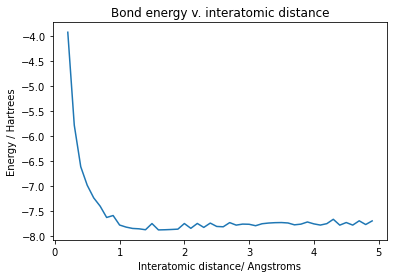

In [46]:
plt.plot(distances , energies)
plt.title('Bond energy v. interatomic distance')
plt.xlabel('Interatomic distance/ Angstroms')
plt.ylabel('Energy / Hartrees')

With SLSQP optimizer

In [49]:
distances = np.arange(0.5 , 4.0 , 0.1)
energies = []
for interdist in distances:
    print('Interatomic distance:' , interdist)
    qubitOp, num_spin_orbitals, num_particles, qubit_reduction, shift = compute_LiH_qubitOp(map_type , interdist)
    # Classically solve for the exact solution and use that as your reference value
    ref = exact_solver(qubitOp , shift)

    # Specify your initial state
    init_state = HartreeFock(num_spin_orbitals,num_particles, qubit_mapping=map_type) 

    # Select a state preparation ansatz
    # Equivalently, choose a parameterization for our trial wave function.
    var_form = UCCSD(num_orbitals=num_spin_orbitals, num_particles=num_particles, qubit_mapping=map_type)

    # Choose where to run/simulate our circuit
    quantum_instance = Aer.get_backend('statevector_simulator')

    # Choose the classical optimizer
    optimizer =  SLSQP(maxiter = 5)

    # Run your VQE instance
    vqe = VQE(qubitOp, var_form, optimizer)
    vqe_results = vqe.run(quantum_instance)

    # Calculating ground state energy from vqe results:
    ground_state_energy = np.real(vqe_results['eigenvalue']) + shift
    energies.append(ground_state_energy)

Interatomic distance: 0.5
HF energy: -10.203473360061933
# of electrons: 4
# of spin orbitals: 12
Reference value: [-7.03973252-1.39932152e-17j]
Interatomic distance: 0.6
HF energy: -9.94542710594224
# of electrons: 4
# of spin orbitals: 12
Reference value: [-7.31334583+6.98406857e-18j]
Interatomic distance: 0.7
HF energy: -9.753847203061564
# of electrons: 4
# of spin orbitals: 12
Reference value: [-7.50092209+6.60690901e-17j]
Interatomic distance: 0.7999999999999999
HF energy: -9.6001847021821
# of electrons: 4
# of spin orbitals: 12
Reference value: [-7.63097825+8.08409765e-17j]
Interatomic distance: 0.8999999999999999
HF energy: -9.469677376536117
# of electrons: 4
# of spin orbitals: 12
Reference value: [-7.72081241+4.11195141e-17j]
Interatomic distance: 0.9999999999999999
HF energy: -9.35489376850856
# of electrons: 4
# of spin orbitals: 12
Reference value: [-7.7822424+1.68606058e-17j]
Interatomic distance: 1.0999999999999999
HF energy: -9.251953751729783
# of electrons: 4
# of s

Text(0, 0.5, 'Energy / Hartrees')

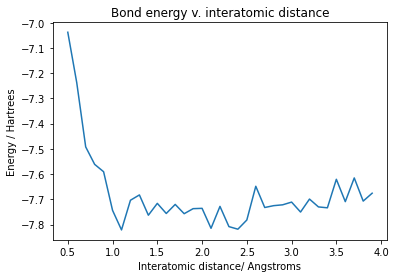

In [50]:
plt.plot(distances , energies)
plt.title('Bond energy v. interatomic distance')
plt.xlabel('Interatomic distance/ Angstroms')
plt.ylabel('Energy / Hartrees')